*This notebook was created as basis for a blog publication on Medium. To write such an article is a task in Udacity's Data Science program. It can be found [here]().* 

## How to predict churn in the automotive service business - and what to learn from it

### Load libraries and data

In [1]:
import numpy as np
import pandas as pd
import datetime
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
color = 'rebeccapurple'
cmap = 'viridis'

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV, train_test_split, learning_curve
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import make_scorer, fbeta_score, average_precision_score,  roc_curve, roc_auc_score, \
    precision_recall_curve, confusion_matrix, classification_report
from sklearn.externals import joblib

from sklearn.ensemble import GradientBoostingClassifier

# display all columns of df
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = 80

In [2]:
churn = pd.read_csv('churnData.csv', low_memory=False)

### EDA

In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49862 entries, 0 to 49861
Data columns (total 43 columns):
target_event               49862 non-null int64
NUM_CONSEC_SERVICES        49862 non-null int64
SUM_INVOICE_AMOUNT         35793 non-null float64
NUM_EVENTS                 49862 non-null int64
LAST_MILEAGE               49861 non-null float64
MEAN_MILEAGE_PER_MNTH      49862 non-null float64
AVG_DIFF_MNTH              49862 non-null int64
age_mnth                   49862 non-null int64
INSPECTION_INTERVAL_UID    49862 non-null object
LIST_PRICE                 49861 non-null float64
END_CUSTOMER_STATUS_UID    49861 non-null object
CAR_BRAND_UID              49862 non-null object
FUEL_TYPE_UID              49861 non-null object
GEAR_TYPE_UID              49861 non-null object
WHEEL_DRIVE_UID            49861 non-null object
NUMBER_OF_DOORS_UID        48854 non-null float64
GEAR_COUNT                 49861 non-null float64
BASE_MARGIN                49862 non-null float64
SALES_T

In [4]:
churn.sample(5)

,target_event,NUM_CONSEC_SERVICES,SUM_INVOICE_AMOUNT,NUM_EVENTS,LAST_MILEAGE,MEAN_MILEAGE_PER_MNTH,AVG_DIFF_MNTH,age_mnth,INSPECTION_INTERVAL_UID,LIST_PRICE,END_CUSTOMER_STATUS_UID,CAR_BRAND_UID,FUEL_TYPE_UID,GEAR_TYPE_UID,WHEEL_DRIVE_UID,NUMBER_OF_DOORS_UID,GEAR_COUNT,BASE_MARGIN,SALES_TYPE,PERSON_LANGUAGE_UID,PERSON_STATE,PERSON_ADRESS_COUNT,ownerAge,REGION_UID,PARTNER_LANGUAGE_UID,IS_PREFERRED_PARTNER,IS_DEALER,PARTNER_STATE,PARTNER_CITY,PARTNER_ADRESS_COUNT,Haushaltstyp,Urbanitaet,Wohneigentumverhaeltnis,Haushaltsgroesse,KaufkraftindexGemeinde,Fahrzeugtyp,Haushaltseinkommen,Fahrzeugklasse,Lebensphase,HaushaltsgroesseFein,Fahrzeugart,dist_metres,duration_days
15776,1,1,NaN,5,10582.0,587.888889,3,40,24 Monate,14650.0,03 Privatkunde,VW-PW,Benzin,Schaltgetriebe,Frontantrieb,5.0,5.0,7.0,up!,Deutsch,TG,2.0,45.0,Ostschweiz,Deutsch,0,1,TG,Kreuzlingen,4,3,1,,4.0,4.0,4,2.0,2,4,4.0,6.0,79.0,523
21036,1,3,1048.60,21,74570.0,1007.702703,3,96,24 Monate,30590.0,03 Privatkunde,VW-PW,Benzin,Schaltgetriebe,Frontantrieb,5.0,5.0,9.0,Polo,Deutsch,BE,2.0,34.0,Espace Mittelland,Deutsch,1,1,BE,Bern,1,2,1,1,3.0,4.0,4,2.0,4,4,3.0,6.0,10586.0,2244
48175,0,2,124.74,6,16870.0,624.814815,4,43,24 Monate,72080.0,52 Privat Kleinflottenfirma,Audi,Benzin,Automat,Allradantrieb,5.0,8.0,7.0,Q5,Deutsch,NW,2.0,33.0,Nordwestschweiz,Deutsch,1,1,AG,Schinznach Bad,1,3,2,1,4.0,8.0,0,0.0,0,4,4.0,0.0,83224.0,803
29324,1,5,213.70,15,115733.0,1585.383562,4,89,24 Monate,52210.0,52 Privat Kleinflottenfirma,VW-PW,Diesel,Automat,Frontantrieb,5.0,6.0,10.0,Passat,Französisch,VD,2.0,35.0,Genferseeregion,Französisch,0,0,GE,Carouge,2,3,2,2,3.0,6.0,3,2.0,5,4,3.0,5.0,37689.0,2225
41738,0,1,1210.05,5,31220.0,1836.470588,3,32,24 Monate,20640.0,03 Privatkunde,SEAT,Benzin,Schaltgetriebe,Frontantrieb,5.0,5.0,12.0,Ibiza,Deutsch,BE,1.0,34.0,Espace Mittelland,Deutsch,0,0,BE,Thun,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37916.0,534


In [5]:
print("Number of numerical columns: {}".format(len(churn.select_dtypes(include = ['int64', 'float64']).columns)))
print("Number of categorical columns: {}".format(len(churn.select_dtypes(include = ['object']).columns)))

Number of numerical columns: 24
Number of categorical columns: 19


**Observation:** Many of the numerical columns are categorical in character and will therefore be transformed to categorical variables.

### Fix Datatypes

In [6]:
# transform datatype of numerical columns with categorical character and of object columns
colsToCat = ['CAR_BRAND_UID', 'GEAR_TYPE_UID', 'FUEL_TYPE_UID','WHEEL_DRIVE_UID', 'PERSON_LANGUAGE_UID', 'SALES_TYPE',
            'PARTNER_LANGUAGE_UID', 'ACTIVE', 'IS_PREFERRED_PARTNER', 'IS_DEALER', 'PARTNER_CITY', 'KANTON_LICENCE_PLATE', 
            'BASE_MARGIN', 'GEAR_COUNT', 'PERSON_ADRESS_COUNT', 'NUMBER_OF_DOORS_UID', 'PARTNER_ADRESS_COUNT', 'PARTNER_STATE',
            'INSPECTION_INTERVAL_UID', 'END_CUSTOMER_STATUS_UID', 'PERSON_STATE', 'REGION_UID'] + list(churn.columns[-13:-2])

for col in colsToCat:
    if col in churn.columns:
        churn[col] = churn[col].astype('category')

In [7]:
#check
churn.info()
print("\nNumber of numerical columns: {}".format(len(churn.select_dtypes(include = ['int64', 'float64']).columns)))
print("Number of categorical columns: {}".format(len(churn.select_dtypes(include = ['category']).columns)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49862 entries, 0 to 49861
Data columns (total 43 columns):
target_event               49862 non-null int64
NUM_CONSEC_SERVICES        49862 non-null int64
SUM_INVOICE_AMOUNT         35793 non-null float64
NUM_EVENTS                 49862 non-null int64
LAST_MILEAGE               49861 non-null float64
MEAN_MILEAGE_PER_MNTH      49862 non-null float64
AVG_DIFF_MNTH              49862 non-null int64
age_mnth                   49862 non-null int64
INSPECTION_INTERVAL_UID    49862 non-null category
LIST_PRICE                 49861 non-null float64
END_CUSTOMER_STATUS_UID    49861 non-null category
CAR_BRAND_UID              49862 non-null category
FUEL_TYPE_UID              49861 non-null category
GEAR_TYPE_UID              49861 non-null category
WHEEL_DRIVE_UID            49861 non-null category
NUMBER_OF_DOORS_UID        48854 non-null category
GEAR_COUNT                 49861 non-null category
BASE_MARGIN                49862 non-null c

### Analyze numerical variables and their correlations

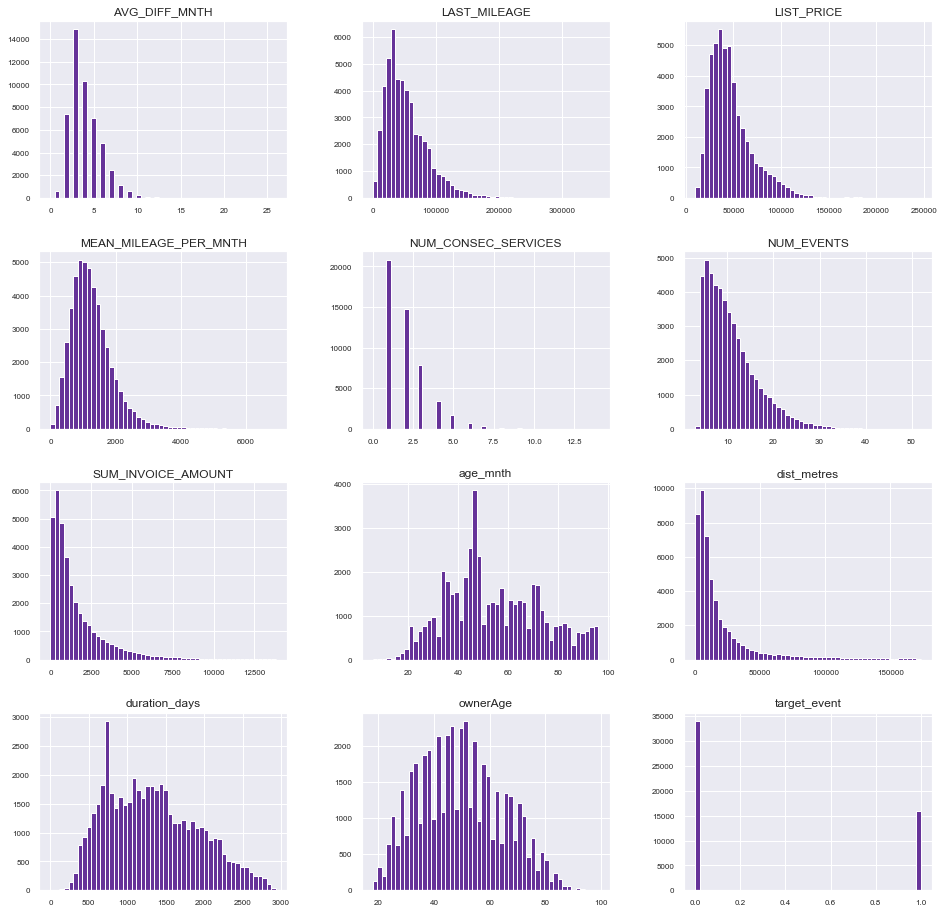

In [8]:
# plot histograms of numerical variables
churn_num = churn.select_dtypes(include = ['float64', 'int64'])    
churn_num.hist(figsize=(16,16), bins=50, xlabelsize=8, ylabelsize=8, color=color);

**Observations:** 
- Most of the data is scewed, and there are some outliers. A tree based model should be able to handle this.
- The 'binary' column 'target_event' is the _dependent variable_. We can see an imbalance in the two classes, this will have to be considered when splitting into train and test sets.

In [9]:
# print distribution of target labels
tDistr = churn['target_event'].value_counts() / len(churn)
print("ACTIVE in % of total: {:4.2f}".format(tDistr[0]))
print("CHURN in % of total: {:4.2f}".format(tDistr[1]))

ACTIVE in % of total: 0.68
CHURN in % of total: 0.32


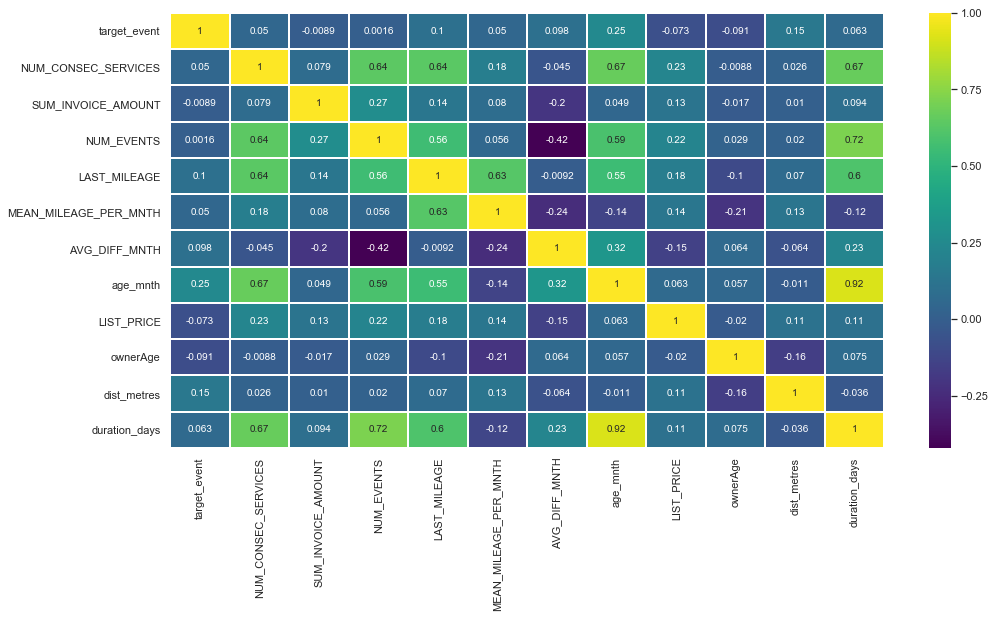

In [10]:
# plot correlation heatmap for numeric variables
plt.figure(figsize=(16,8))
sns.heatmap(churn_num.corr(), cmap=cmap, linecolor='white', linewidth=1, annot=True);

**Observations:** Generally there are no strong correlations in regard to the target variable (see first row). Only three variables have a correlation of >= 0.1 (in absolute terms): 
* age_mnth
* dist_metres
* LAST_MILEAGE (highly correlated with age_mnth)
    
There are a few strong correlations between the independent variables, but again: a tree based model should be able to handle this.

### Analyze categorical variables and their distributions in regard to the target classes

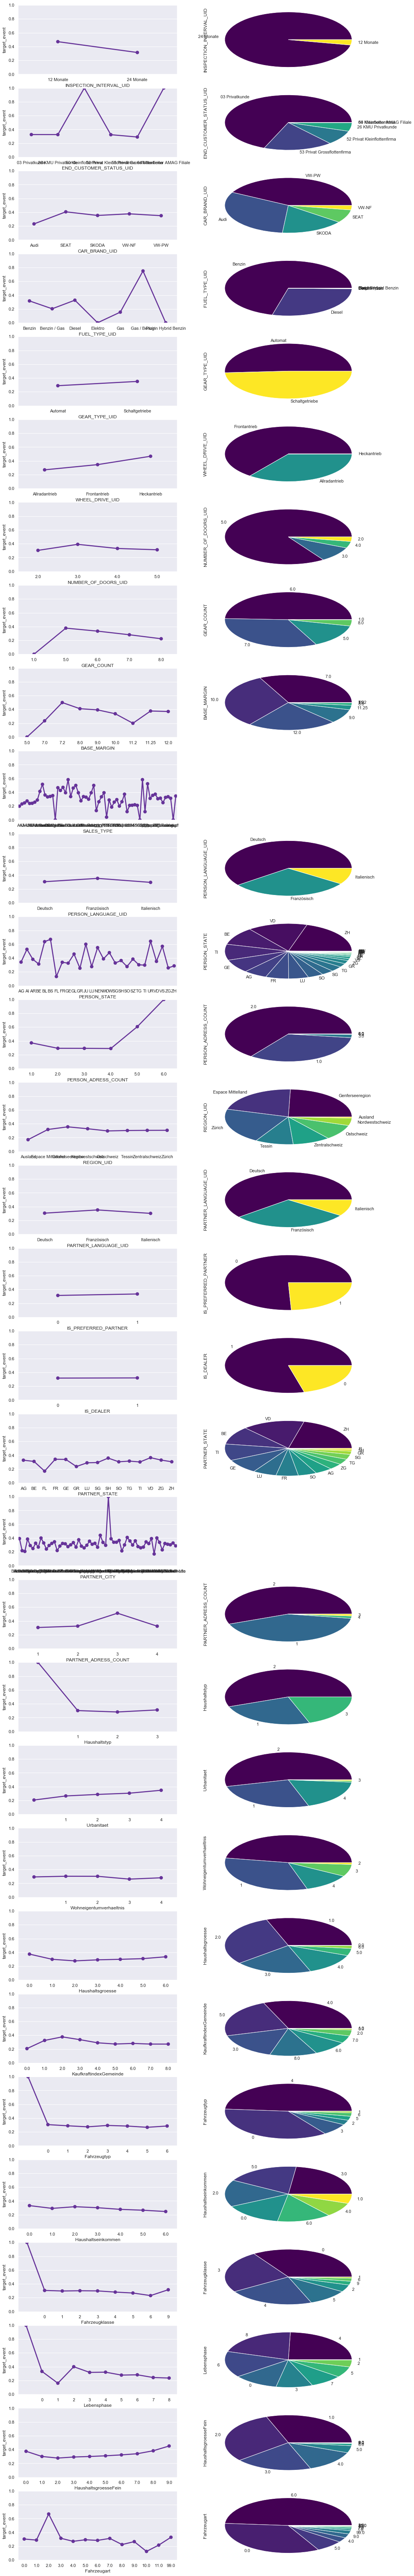

In [11]:
# define function
def correlation_CatToClass(df, target, figsize=(16, 16), ylim=[0,1], color='rebeccapurple', cmap='viridis'):
    """Create pointplots (and corresponding piecharts) to show correlations between all categorical columns 
    and target classes in DataFrame.
    Params
    ======
        df: DataFrame
        target: Column name of target variable in string format (variable has to be in numerical format)
        figsize: default is (16, 16)
        ylim: scale of y-axis, default is [0,1]
        color: default is 'rebeccapurple'
        cmap: default is 'viridis'
    """
    df_cat = df.select_dtypes(include = ['category'])
    position=0
    plt.figure(figsize=figsize)
#     plt.tight_layout(w_pad=1)
    for col in df_cat.columns:
        df_plot = df[[col, target]].groupby(col, as_index=False).mean().sort_values(by=target, ascending=False)
        position +=1
        plt.subplot(df_cat.shape[1],2,position)
        plt.ylim(ylim)
        sns.pointplot(x=col, y=target, data=df_plot,color=color)
        if df[col].nunique() <= 30:
            position +=1
            plt.subplot(df_cat.shape[1],2,position)
            df[col].value_counts().plot(kind='pie', cmap = cmap)
        else: position +=1
    return df_cat

# call function
correlation_CatToClass(churn, 'target_event', figsize=(16, 120));

**Explanation:** The pointplots show the mean distribution of the target classes for the different categories of a variable (see pies for the distribution of these categories). As there are 32% of CHURN instances in the set a mean of 0.32 indicates that no effect can be seen. Higher means show more CHURN instances as on average, lower means show the contrary. 

**Observations:** These are harder to interpret ... many visually significant differences are due to categories that are very low in count. Nevertheless, the most interesting seem to be: 
* CAR_BRAND_UID: Audi higher than other brands
* GEAR_TYPE_UID --> correlation with brand, age?
* WHEEL_DRIVE_UID --> correlation with brand, age?
* GEAR_COUNT_UID --> correlation with brand, age?
* BASE_MARGIN (7 much higher than 10,12) --> correlation with brand, age?
* PERSON_LANGUAGE_UID / REGION_UID / PARTNER_LANGUAGE_UID (correlated for shure)
* SALES_TYPE?
* PARTNER_CITY? --> one outlier
* PERSON_ADRESS_COUNT?

### Preprocessing for ML: Remove NaN

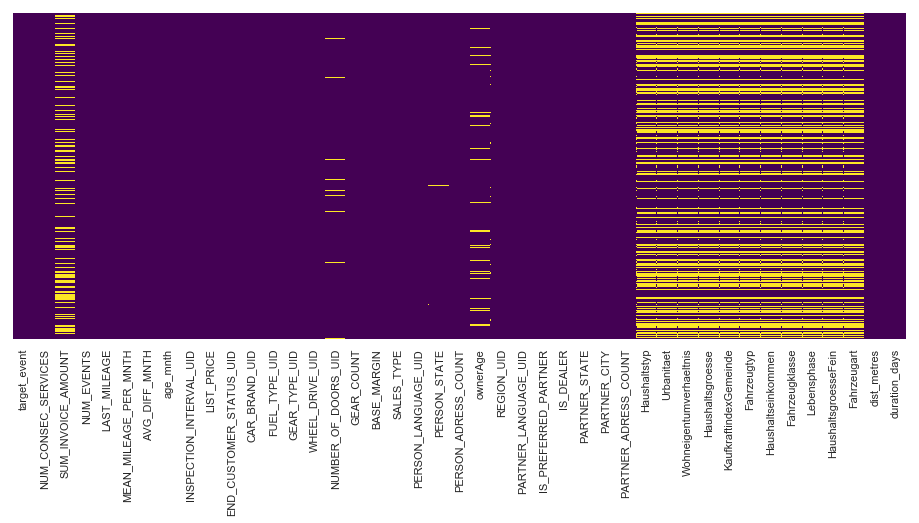

In [12]:
# print overview of missing values
plt.figure(figsize=(16,6))
sns.heatmap(churn.isnull(), yticklabels=False, cbar=False, cmap='viridis');

In [13]:
# print number of NaNs for every column with NaN
print("Number of NaN per column:")
for col in churn:
    if churn[col].isnull().sum() > 0:
        print(churn[col].name +": "+str(churn[col].isnull().sum()))

Number of NaN per column:
SUM_INVOICE_AMOUNT: 14069
LAST_MILEAGE: 1
LIST_PRICE: 1
END_CUSTOMER_STATUS_UID: 1
FUEL_TYPE_UID: 1
GEAR_TYPE_UID: 1
WHEEL_DRIVE_UID: 1
NUMBER_OF_DOORS_UID: 1008
GEAR_COUNT: 1
PERSON_STATE: 108
ownerAge: 3189
Haushaltstyp: 15963
Urbanitaet: 15963
Wohneigentumverhaeltnis: 15963
Haushaltsgroesse: 15963
KaufkraftindexGemeinde: 15963
Fahrzeugtyp: 15963
Haushaltseinkommen: 15963
Fahrzeugklasse: 15963
Lebensphase: 15963
HaushaltsgroesseFein: 15963
Fahrzeugart: 15964


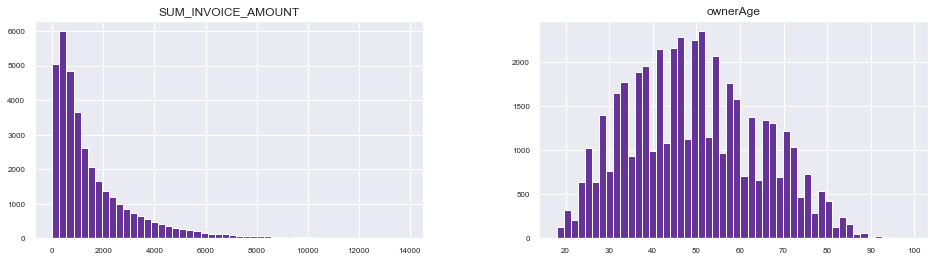

In [14]:
# check numerical columns with NaN
churn[['ownerAge', 'SUM_INVOICE_AMOUNT']].hist(figsize=(16,4), bins=50, xlabelsize=8, ylabelsize=8, color=color);

In [15]:
# remove NaN
colsToImputeNum = ['ownerAge', 'SUM_INVOICE_AMOUNT']
colsToImputeCat = ['NUMBER_OF_DOORS_UID']

# impute median for NaN in specified numerical cols   
for col in colsToImputeNum:
    if col in churn.columns:
        print("{} - median value to impute: {}".format(col, churn[col].median()))
        churn[col].fillna(churn[col].median(), inplace=True)
    else:
        print(col + " not found")
        
# impute mode for NaN in specified categorical cols
for col in colsToImputeCat:
    if col in churn.columns:
        print("{} - most frequent value to impute: {}".format(col, churn[col].value_counts().index[0]))
        churn[col].fillna(churn[col].value_counts().index[0], inplace=True)
    else:
        print(col + " not found")
            
churn.dropna(subset=['LAST_MILEAGE', 'LIST_PRICE', 'FUEL_TYPE_UID'], inplace=True)

ownerAge - median value to impute: 49.0
SUM_INVOICE_AMOUNT - median value to impute: 968.0
NUMBER_OF_DOORS_UID - most frequent value to impute: 5.0


In [16]:
# print number of NaNs for every column with NaN
print("Number of NaN per column:")
for col in churn:
    if churn[col].isnull().sum() > 0:
        print(churn[col].name +": "+str(churn[col].isnull().sum()))

Number of NaN per column:
PERSON_STATE: 108
Haushaltstyp: 15962
Urbanitaet: 15962
Wohneigentumverhaeltnis: 15962
Haushaltsgroesse: 15962
KaufkraftindexGemeinde: 15962
Fahrzeugtyp: 15962
Haushaltseinkommen: 15962
Fahrzeugklasse: 15962
Lebensphase: 15962
HaushaltsgroesseFein: 15962
Fahrzeugart: 15963


**Decision:** the remaining NaN will be 'dummied' during one-hot-encoding

### Preprocessing for ML: One-hot-encode the categorical variables

In [17]:
# separate target variable from predictor variables
X = churn.drop('target_event', axis=1)  # note: .drop() creates a copy of the df and does not affect the orgininal
y = churn['target_event'].copy()

In [18]:
# check X-shape before one-hot-encoding
X.shape

(49859, 42)

In [19]:
# for each cat add dummy var, drop original column
X_cat = X.select_dtypes(include='category').columns
for col in  X_cat:
        X = pd.concat([X.drop(col, axis=1), pd.get_dummies(X[col], prefix=col, prefix_sep='-', drop_first=True, dummy_na=True)], axis=1)

In [20]:
# check X-shape after one-hot-encoding
X.shape

(49859, 332)

**Observation:** X has now 332 columns (instead of 42 as before).

In [21]:
# safety check: print number of NaNs for every column with NaN
print("Number of NaN per column:")
for col in X:
    if X[col].isnull().sum() > 0:
        print(X[col].name +": "+str(X[col].isnull().sum()))

Number of NaN per column:


### Split train and test

In [22]:
# split train and test sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=666, stratify=y)

In [23]:
# safety check distribution of target labels in y_train
print("CHURN in % of total: {:4.2f}".format(np.sum(y_train) / len(y_train)))

CHURN in % of total: 0.32


In [ ]:
and STOP HERE ;-) # delete this cell in the end

### Initialize, validate and fit Gradient Boosting Classifier

In [25]:
# initalize model
GBC = GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.05, loss='deviance', max_depth=6, 
                                 max_features=None, max_leaf_nodes=None,min_impurity_decrease=0.0, min_impurity_split=None, 
                                 min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=500, 
                                 n_iter_no_change=None, presort='auto', random_state=None, subsample=1.0, tol=0.0001, 
                                 validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# apply sklearns learning_curve utility on training set with 5-fold CV
N, trainCurve, valCurve = learning_curve(GBC, X_train, y_train, cv=StratifiedKFold(5), 
                                         scoring=make_scorer(fbeta_score, beta=0.5), train_sizes=np.linspace(0.01,1.0,20),
                                         n_jobs=-1, verbose=10)

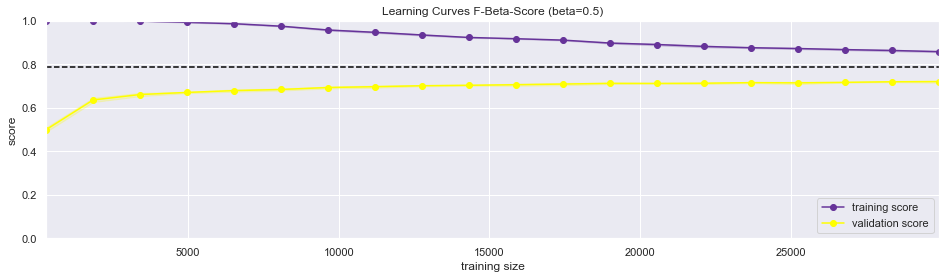

In [30]:
# calculate means and std deviation
trainCurveMean = np.mean(trainCurve, axis=1)
valCurveMean = np.mean(valCurve, axis=1)
trainCurveStd = np.std(trainCurve, axis=1)
valCurveStd = np.std(valCurve, axis=1)
# plot learning curves
plt.figure(figsize=(16,4))
plt.plot(N, trainCurveMean, color='rebeccapurple', marker='o', label='training score')
plt.plot(N, valCurveMean, color='yellow', marker='o', label='validation score')
plt.fill_between(N, trainCurveMean - trainCurveStd,trainCurveMean + trainCurveStd, alpha=0.2, color="rebeccapurple")
plt.fill_between(N, valCurveMean - valCurveStd, valCurveMean + valCurveStd, alpha=0.2, color="yellow")
plt.hlines(np.mean([trainCurveMean[-1], valCurveMean[-1]]), N[0], N[-1], color='black', linestyle='dashed')
# styling
plt.ylim(0,1)
plt.xlim(N[0], N[-1])
plt.xlabel('training size')
plt.ylabel('score')
plt.title("Learning Curves F-Beta-Score (beta=0.5)")
plt.legend(loc='lower right');

In [32]:
# fit model to train data
GBC.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [24]:
# save model to file for later reuse
# joblib.dump(GBC, "XGB.joblib.dat") 
# print("Saved model to: XGB.joblib.dat")

# # reload model if needed
GBC = joblib.load("XGB.joblib.dat") 
print("Loaded model from: XGB.joblib.dat")

Loaded model from: XGB.joblib.dat


### Evaluate on test set

In [25]:
# make predictions for test set
predictions = GBC.predict(X_test) 
# evaluate predictions 
fBetaFinal = fbeta_score(y_test, predictions, beta = 0.5) 
print("F-Beta-Score on test data: {:.4f}".format(fBetaFinal))

F-Beta-Score on test data: 0.7307


In [26]:
# print additional metrics
print("Confusion Metrics\n")
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("CHURNERS identified correctly (true positives): {} ({:.0f}% of total CHURN)".format(tp, (tp/(tp+fn)*100)))
print("ACTIVES misclassified as CHURN (false positives): {} ({:.0f}% of all positives)".format(fp, (fp/(tp+fp)*100)))
print("Precision: {:.2f}".format(tp/(tp+fp)))

print("\nClassification Report\n")
print(classification_report(y_test, predictions))

Confusion Metrics

CHURNERS identified correctly (true positives): 2552 (64% of total CHURN)
ACTIVES misclassified as CHURN (false positives): 820 (24% of all positives)
Precision: 0.76

Classification Report

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      8490
           1       0.76      0.64      0.69      3975

   micro avg       0.82      0.82      0.82     12465
   macro avg       0.80      0.77      0.78     12465
weighted avg       0.82      0.82      0.82     12465



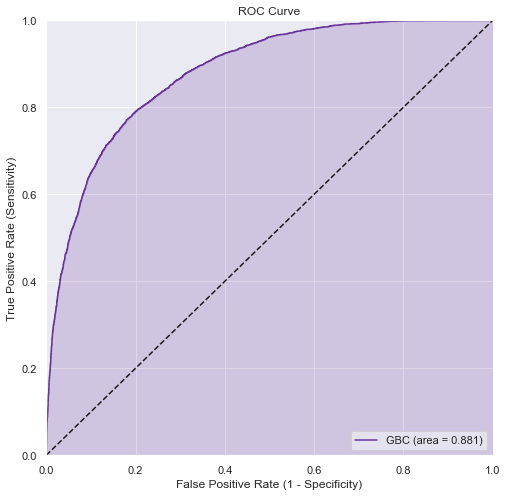

In [27]:
# ROC-curve
# get probabilities of class membership for instances in test set (2nd col is probability for CHURN)
probabilities = GBC.predict_proba(X_test)
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probabilities[:,1])
roc_auc = roc_auc_score(y_test, probabilities[:,1])
# plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label= "{} (area = {:.3f})".format('GBC', roc_auc), color=color)
plt.fill_between(fpr, tpr, alpha=0.2, color='rebeccapurple')
plt.plot([0, 1], [0, 1], 'k--')
# styling
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=12)
plt.ylabel('True Positive Rate (Sensitivity)', size=12)
plt.title('ROC Curve', size=12)
plt.legend(loc='lower right');

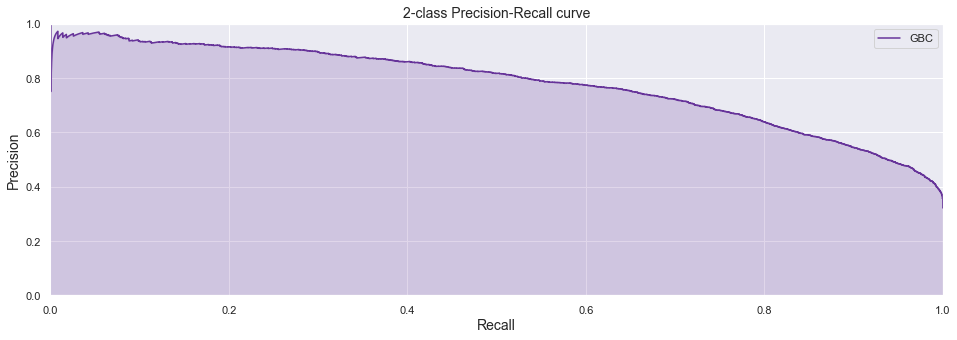

In [44]:
# Precision-Recall-Curve
average_precision = average_precision_score(y_test, probabilities[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, probabilities[:,1])
# plot precision-recall curve
plt.figure(figsize=(16,5))
plt.plot(recall, precision, label='GBC', color=color)
plt.fill_between(recall, precision, alpha=0.2, color='rebeccapurple')
# styling
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve', fontsize=14)
plt.legend(loc='best')
# safe as png
plt.savefig('curve.png');

In [32]:
# combine probabilities for CHURN, predictions and testLabels in dataframe ordered by probability (highest)
finalResultsDF = pd.DataFrame({'proba': probabilities[:,1], 'pred' : predictions, 'label' : np.array(y_test)}
                             ).sort_values('proba', ascending=False).reset_index().drop('index', axis=1)
totalChurnPred = finalResultsDF['pred'].sum()
# calculate and print metrics for different thresholds of predicted CHURN probabilty
probThresholds = np.arange(0.5, 1.0, 0.1)
for threshold in probThresholds:
    df = finalResultsDF[finalResultsDF['proba'] >= threshold]
    tn, fp, fn, tp = confusion_matrix(df['label'], df['pred']).ravel()
    print("Probability threshold for CHURN prediction: {:.1f}% ({:.1f}% of all CHURN predictions)".format(
        threshold*100, (len(df)/totalChurnPred)*100))
    print("  Precision: {:.1f}%".format((tp/(tp+fp)*100)))

Probability threshold for CHURN prediction: 50.0% (100.0% of all CHURN predictions)
  Precision: 75.7%
Probability threshold for CHURN prediction: 60.0% (76.1% of all CHURN predictions)
  Precision: 80.6%
Probability threshold for CHURN prediction: 70.0% (56.4% of all CHURN predictions)
  Precision: 85.7%
Probability threshold for CHURN prediction: 80.0% (37.0% of all CHURN predictions)
  Precision: 90.2%
Probability threshold for CHURN prediction: 90.0% (16.3% of all CHURN predictions)
  Precision: 93.2%


### Examine feature importances

In [33]:
GBC_weights = GBC.feature_importances_
print(GBC_weights[:10])

[0.03632557 0.02056727 0.01734207 0.02435399 0.04070427 0.01987792
 0.35404193 0.02172238 0.02375624 0.05839705]


In [34]:
# zip attribute names and weights
GBC_weights_named = sorted(zip(GBC_weights, X.columns), reverse=True)
GBC_weights_named = pd.DataFrame(GBC_weights_named)
GBC_weights_named[:20]

,0,1
0,0.354042,age_mnth
1,0.256738,duration_days
2,0.058397,dist_metres
3,0.040704,MEAN_MILEAGE_PER_MNTH
4,0.036326,NUM_CONSEC_SERVICES
5,0.024354,LAST_MILEAGE
6,0.023756,ownerAge
7,0.021722,LIST_PRICE
8,0.020567,SUM_INVOICE_AMOUNT
9,0.019878,AVG_DIFF_MNTH


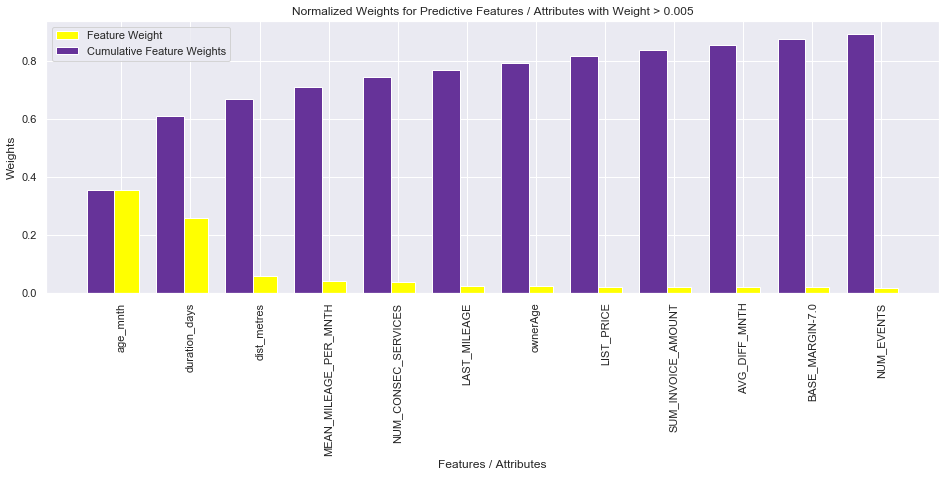

In [35]:
# plot features with biggest weight
dfPlot = GBC_weights_named[GBC_weights_named[0] > 0.005]
fig = plt.figure(figsize = (16,5))
plt.bar(np.arange(len(dfPlot)), dfPlot[0], width = 0.5, align="center", color = 'yellow', \
      label = "Feature Weight")
plt.bar(np.arange(len(dfPlot)) - 0.3, np.cumsum(dfPlot[0]), width = 0.4, align = "center", color = 'rebeccapurple', \
      label = "Cumulative Feature Weights")
# styling
plt.title("Normalized Weights for Predictive Features / Attributes with Weight > 0.005")
plt.ylabel("Weights")
plt.xlabel("Features / Attributes")
plt.xticks(np.arange(len(dfPlot)), dfPlot[1], rotation=90)
plt.legend(loc = 'upper left');

**Observation:** Of the 12 features with weight > 0.005 11 are numerical. This is suspicious. It may be that feature importance calculated this way does not show the true picture. Because categorical features go through one-hot encoding and are split up into N sub-categorical features, each of these sub-categorical features competes separately with the rest of all the sub-categorical features and all numerical features. So it should be much easier for a numerical feature to get a higher importance ranking. 

The issue is discussed [here](https://discuss.xgboost.ai/t/feature-importance-between-numerical-and-categorical-features/245/2).


### Re-examine feature importance with cumulative weights for categorical features

In [36]:
# split variable names into category and sub-category
GBC_weights_named['category'] = GBC_weights_named[1].str.split('-').str.get(0)
GBC_weights_named['sub-category'] = GBC_weights_named[1].str.split('-').str.get(1)
# group-by category and sum the weights
GBC_weights_cum = GBC_weights_named.groupby('category').sum().sort_values(0, ascending=False)
GBC_weights_cum['weights'] = GBC_weights_cum[0]
GBC_weights_cum.drop(0, axis=1, inplace=True)
GBC_weights_cum['sum'] = GBC_weights_cum['weights'].cumsum()

In [37]:
# check
display(GBC_weights_cum[:20])
print(len(GBC_weights_cum))
print(GBC_weights_cum['weights'].sum())

,weights,sum
category,,
age_mnth,0.354042,0.354042
duration_days,0.256738,0.610780
dist_metres,0.058397,0.669177
MEAN_MILEAGE_PER_MNTH,0.040704,0.709881
NUM_CONSEC_SERVICES,0.036326,0.746207
LAST_MILEAGE,0.024354,0.770561
ownerAge,0.023756,0.794317
LIST_PRICE,0.021722,0.816040
BASE_MARGIN,0.021451,0.837491


42
1.0


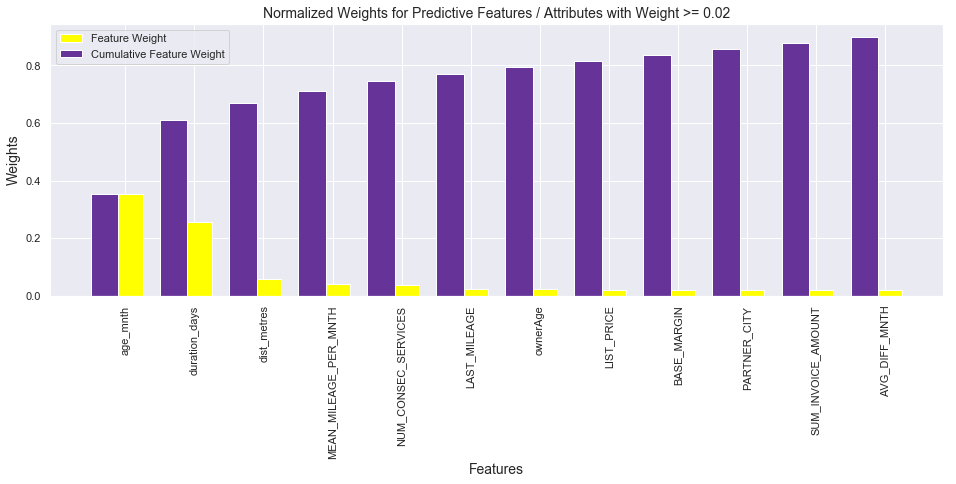

In [43]:
# plot features with biggest weight
dfPlot = GBC_weights_cum[:12]
fig = plt.figure(figsize = (16,5))
plt.bar(np.arange(len(dfPlot)), dfPlot['weights'], width = 0.5, align="center", color = 'yellow', \
      label = "Feature Weight")
plt.bar(np.arange(len(dfPlot)) - 0.3, np.cumsum(dfPlot['weights']), width = 0.4, align = "center", color = 'rebeccapurple', \
      label = "Cumulative Feature Weight")
# styling
plt.title("Normalized Weights for Predictive Features / Attributes with Weight >= 0.02", fontsize=14)
plt.ylabel("Weights", fontsize=14)
plt.xlabel("Features", fontsize=14)
plt.xticks(np.arange(len(dfPlot)), dfPlot.index, rotation=90)
plt.legend(loc = 'upper left')
# safe as png
plt.savefig('weights.png');

**Observation:** The effect of te re-calculation has been smaller than expected. There are now two categorical variables in the (lower) top 12 (Base_Margin and Partner_City).

### Explore / interpret the results

In [45]:
# create dataframe with most important variables only
churnTOP = churn[['target_event', 'duration_days', 'age_mnth', 'dist_metres', 'MEAN_MILEAGE_PER_MNTH', 'NUM_CONSEC_SERVICES']]

In [46]:
# calculate some additional features for exploration
churnTOP = churnTOP.copy()
# car age in 24-month bins
churnTOP['age_24month_bins'] = pd.cut(churnTOP['age_mnth'], bins=[0, 24, 48, 72, 96])
# car age in days
churnTOP['age_days'] = churnTOP['age_mnth'].apply(lambda x: x*30)
# difference between car's age (in days) and duration of customer relationship (also in days)
churnTOP['age_diff'] = churnTOP['age_days'] - churnTOP['duration_days']
churnTOP['age_diff']= np.where((churnTOP['age_diff'] < 0), 0, churnTOP['age_diff'])

In [47]:
# check
churnTOP

,target_event,duration_days,age_mnth,dist_metres,MEAN_MILEAGE_PER_MNTH,NUM_CONSEC_SERVICES,age_24month_bins,age_days,age_diff
0,1,1870,79,2805.0,1286.935484,1,"(72, 96]",2370,500
1,0,1987,82,2805.0,737.424242,5,"(72, 96]",2460,473
2,1,1929,86,2805.0,828.125000,1,"(72, 96]",2580,651
3,1,2055,90,2805.0,720.588235,1,"(72, 96]",2700,645
4,1,1569,73,2805.0,1100.882353,3,"(72, 96]",2190,621
5,0,2083,72,2805.0,757.073529,4,"(48, 72]",2160,77
6,0,2129,75,2805.0,274.114286,3,"(72, 96]",2250,121
7,0,2653,88,2805.0,879.022988,3,"(72, 96]",2640,0
8,1,1988,88,2805.0,1990.848485,2,"(72, 96]",2640,652
9,1,1676,78,2805.0,1269.982143,3,"(72, 96]",2340,664


C:\Users\r2d4\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\r2d4\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\r2d4\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


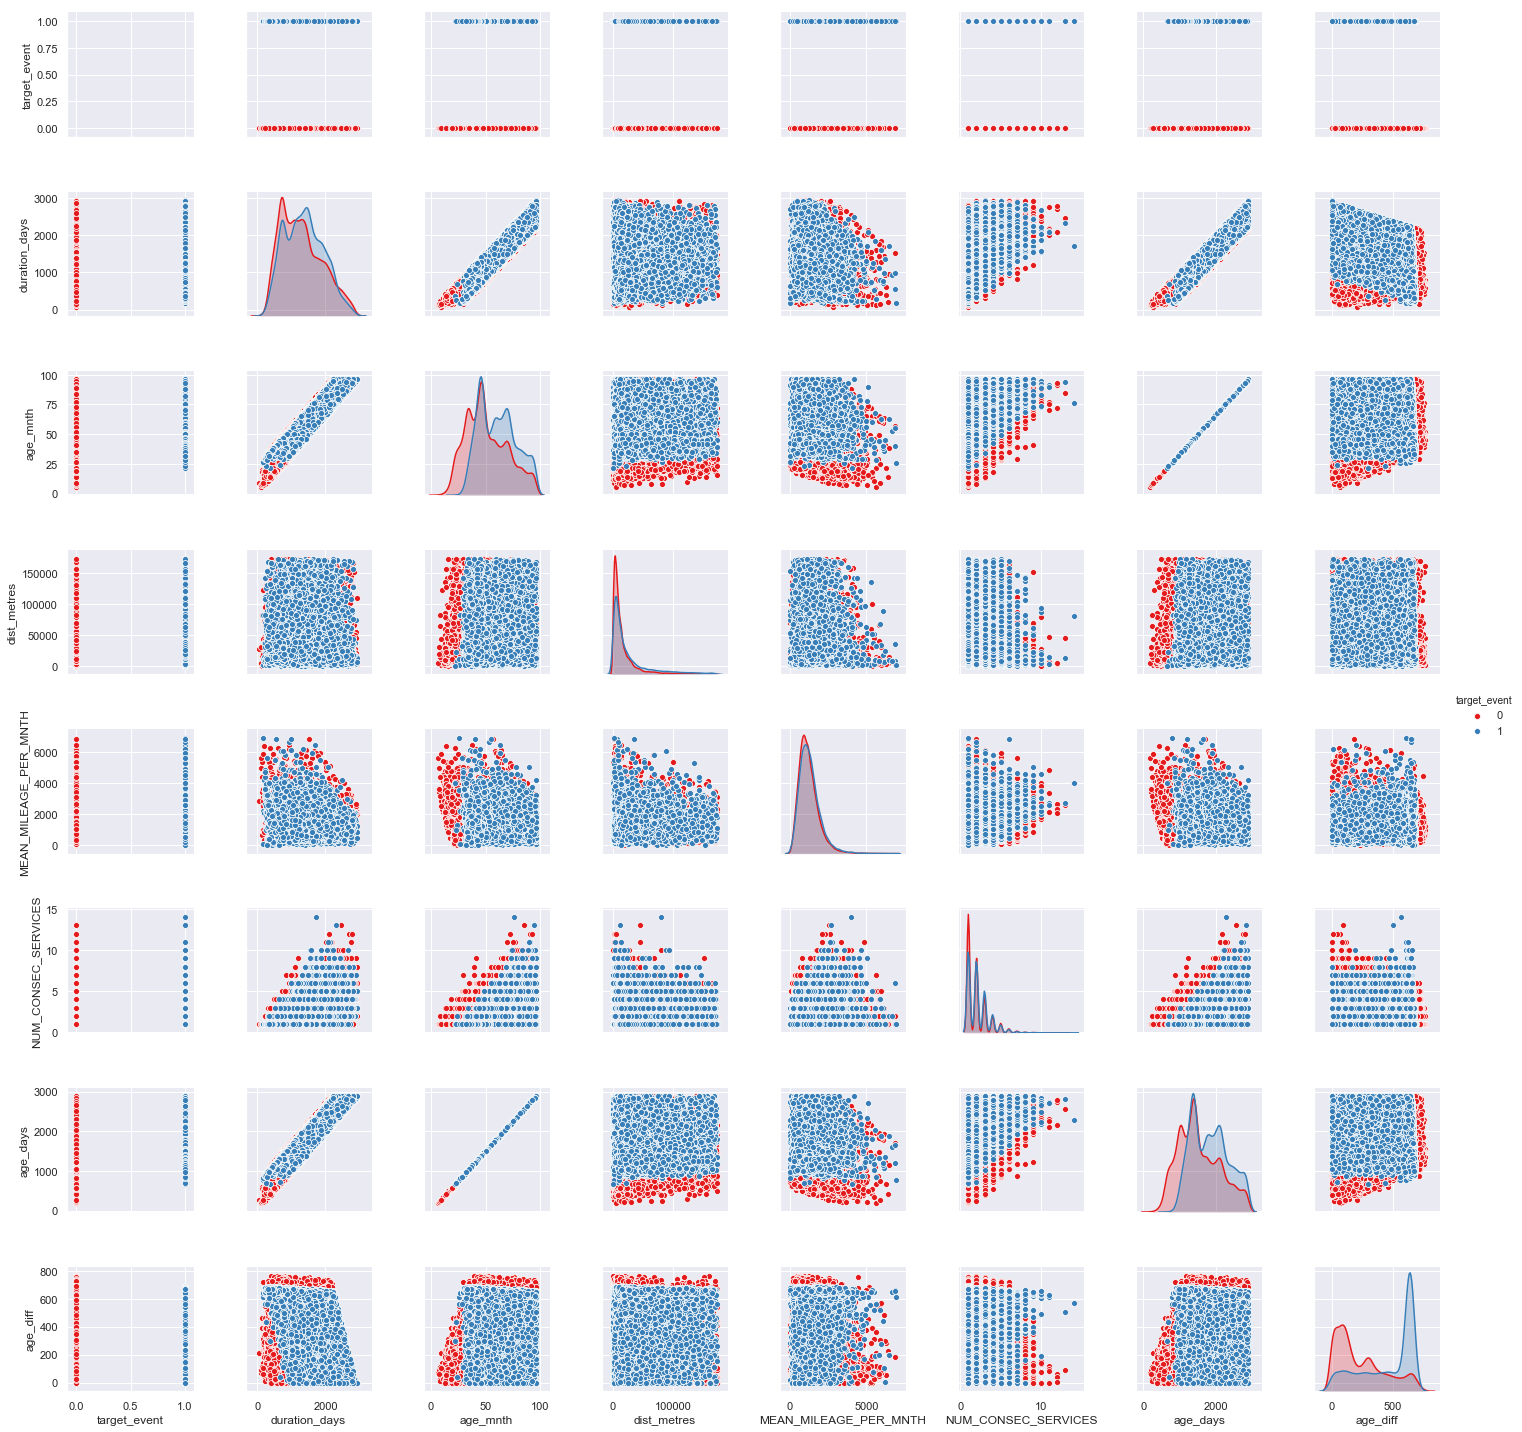

In [47]:
# pairplot
sns.pairplot(churnTOP, hue='target_event', palette='Set1');

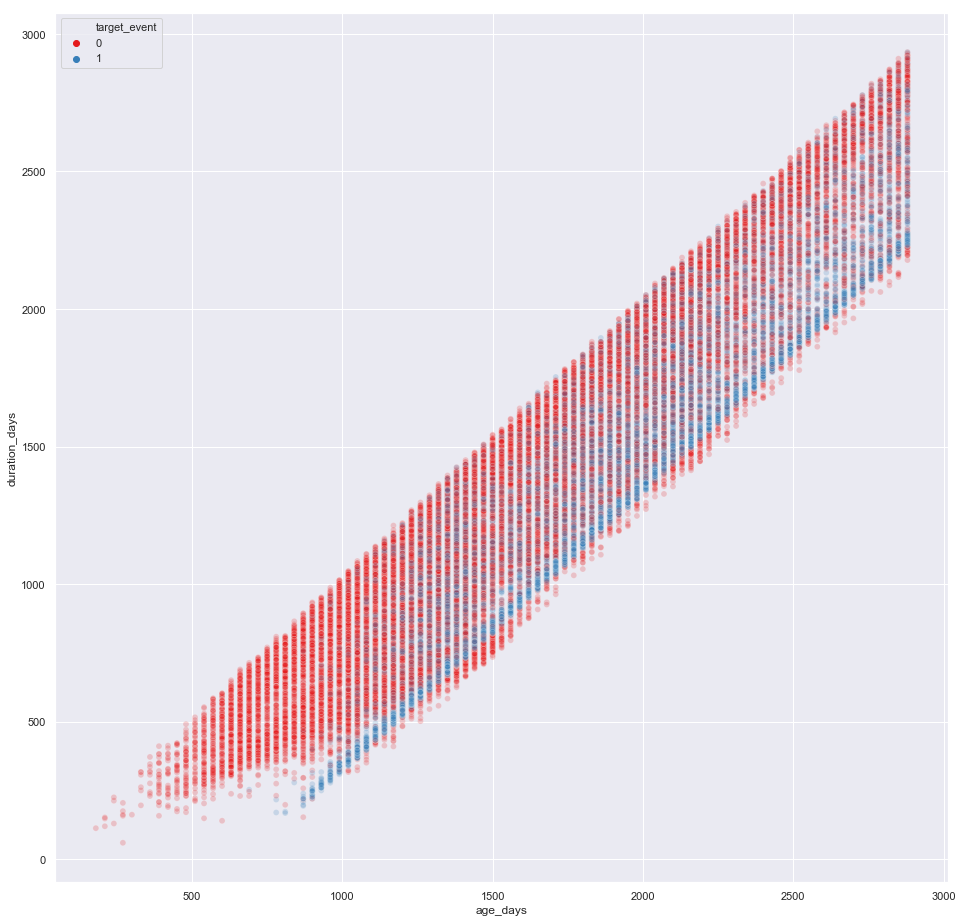

In [43]:
# zoom on relation of car's age and duration of customer relationship with the company (first to last event in days)
plt.figure(figsize=(16,16))
sns.scatterplot('age_days', 'duration_days', data=churnTOP, hue='target_event', alpha=0.2, palette='Set1');

**Observation:** These variables are highly correlated (92%, see correlation map above) but it can be seen that nevertheless there is a clear distinction between CHURN and ACTIVE! Age and duration are near congruent / the same value (in days) for ACTIVE customers and up to roughly 2 years (700-800) apart for CHURNERS. 

The data seems a bit murky (note the 'active' customers with difference higher than the churners) and some investigation into the consistency of the data recordings and the initial data preparation will have to be made.

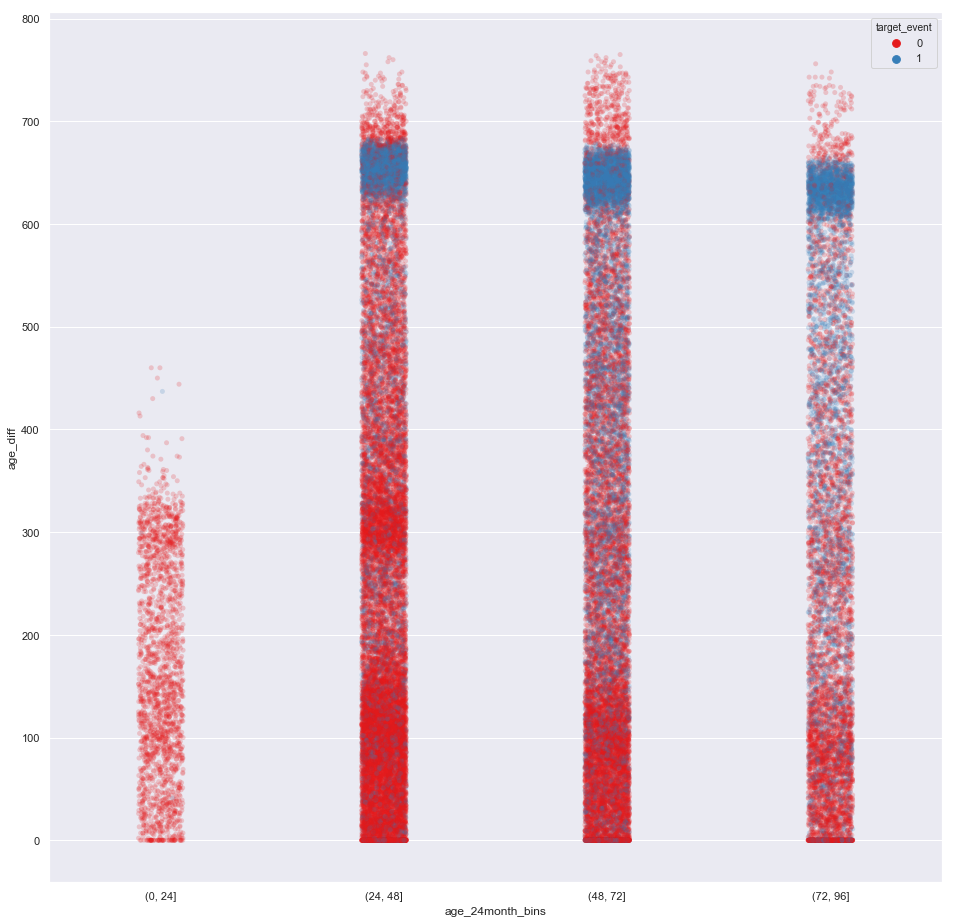

In [27]:
# explore new feature 'age_diff' (difference of age and duration) and binned age of a car
plt.figure(figsize=(16,16))
sns.stripplot('age_24month_bins', 'age_diff', data=churnTOP, hue='target_event', alpha=0.2, jitter=True, palette='Set1');

**Observation:** The data here is definitively somewhat problematic, because the beginning of the customer relationship has not been calculated starting with the purchase date but with the first service visit. Nevertheless a trend can be seen, as the next visualization will make clearer.

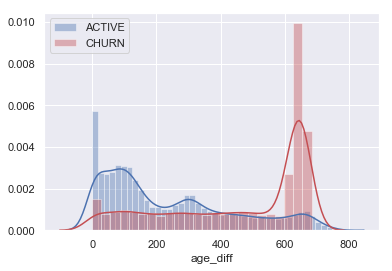

In [29]:
# plot histograms for difference of age and duration for both target labels
sns.distplot(churnTOP['age_diff'][churnTOP['target_event'] == 0], label='ACTIVE')
sns.distplot(churnTOP['age_diff'][churnTOP['target_event'] == 1], color="r", label='CHURN')
plt.legend();

**Observation:** The peak in churn > 600 days has probably to do with the definition / fashion of how the churners have been labeled. But one thing seems to become clear: The bigger the difference between a car's age (as recorded in the company's CRM-system) and the duration of the customer relationship (first to last visit), the less frequent / recent the data has been updated in the systems, wich means the customer has not shown up often in the past year(s). 

If the difference is > 200 days the proportion of active customers drops dramatically. 